In [431]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import sys, os, time

import theano.tensor as T
from theano import function, pp, In, shared, ifelse, Mode, scan

%matplotlib inline

In [57]:
print('Running Python ' + sys.version.split(' ')[0])

Running Python 3.5.2


# Basics

## Algebra

### Adding two scalars

In [35]:
x = T.dscalar('x')
y = T.dscalar('y')

z = x + y

f = function([x, y], z)

In [49]:
type(x)

theano.tensor.var.TensorVariable

In [69]:
type(z)

theano.tensor.var.TensorVariable

In [58]:
print(pp(z))

(x + y)


In [82]:
# declare variable
a = T.vector('a')
b = T.vector('b')
# build symbolic expression
out = a ** 2 + b ** 2 + 2 * a * b
# compile function
f = function([a, b], out)
print(f([0, 1, 2], [0, 1, 2]))

[  0.   4.  16.]


### Logistic function

In [93]:
x = T.dmatrix('x')
s = 1 / (1  + T.exp(-x))

logistic = function([x], s)
logistic([[0, 1], [-1, -2]])

array([[ 0.5       ,  0.73105858],
       [ 0.26894142,  0.11920292]])

### Computing More than one Thing at the Same Time

In [99]:
a, b = T.dmatrices('a', 'b')
diff = a - b
abs_diff = np.abs(diff)
diff_squared = diff ** 2
f = function([a,b],[diff, abs_diff, diff_squared])

In [103]:
f([[2]], [[10]])

[array([[-8.]]), array([[ 8.]]), array([[ 64.]])]

### Setting a Default Value for an Argument

In [107]:
x, y = T.dscalars('x', 'y')
z = x + y
f = function([x, In(y, value=1)], z)
f(33)

array(34.0)

In [111]:
x, y, w = T.dscalars('x', 'y', 'w')
z = (x + y) * w
f = function([x, In(y, value=1), In(w, value=2, name='w_by_name')], z)

In [120]:
f(x=1,y=2,w_by_name=3)

array(9.0)

### Using Shared Variables

In [134]:
state = shared(0)
inc = T.iscalar('inc')
accumulator = function([inc], inc, updates=[(state, state+inc)])

In [136]:
print(state.get_value())
accumulator(1)
print(state.get_value())
accumulator(30)
print(state.get_value())

51
52
82


In [137]:
state.set_value(-1)
accumulator(3)
print(state.get_value())

2


In [138]:
decrementor = function([inc], state, updates=[(state, state-inc)])

In [139]:
decrementor(100)
print(state.get_value())

-98


In [147]:
fn_of_state = state * 2 + inc
# The type of foo must match the shared variable we are replacing
# with the ``givens``
foo = T.scalar(dtype=state.dtype)
skip_shared = function([inc, foo], fn_of_state, givens=[(state, foo)])

In [152]:
print(state.get_value())

-98


In [153]:
skip_shared(1, 3)

array(7)

In [155]:
print(state.get_value())

-98


In [157]:
new_state = shared(0)
new_accumulator = accumulator.copy(swap={state:new_state})
new_accumulator(100)

[array(100, dtype=int32)]

In [158]:
print(new_state.get_value())

100


## Using Random Numbers

### Brief Example

In [174]:
srng = T.shared_randomstreams.RandomStreams(seed=234)
rv_u = srng.uniform((2,2))
rv_n = srng.normal((2,2),avg=0, std=1)

f = function([], rv_u)
g = function([], rv_n)
nearly_zeros = function([], rv_u + rv_u - 2 * rv_u)

In [176]:
nearly_zeros()

array([[ 0.,  0.],
       [ 0.,  0.]])

## Logistic Regression example

In [349]:
class Dataset(object):
    def __init__(self, xTr, yTr):
        self.xTr = xTr
        self.yTr = yTr
    def __repr__(self):
        return 'Dataset X: [%d x %d]; Y: [%d]' % (self.xTr.shape[0], self.xTr.shape[1], self.yTr.shape[0])

# random number generator
rng = np.random

# training sample size
N = 400
feats = 784

# dataset D: Dataset(input values, target class)
D = Dataset(rng.randn(N, feats), rng.randint(0, 2, N))

# declare theano symbolic variables; not shared because they don't change
x = T.dmatrix('x')
y = T.dvector('y')

# initialize the weight vector w randomly
# 
# this and the following bias variable b
# are shared so they keep their values
# between training iterations (updates)
w = shared(rng.randn(feats), name='w')

# initialize bias term
b = shared(0., name='b')

initialize theano graph

In [350]:
# Probability that target = 1
p_1 = 1 / (1 + T.exp(-T.dot(x,w) + b))
print(pp(p_1))
# The prediction thresholded
prediction = p_1 > 0.5
print(pp(prediction))
# cross-entropy function
xent = -y * T.log(p_1) - (1 - y) * T.log(1 - p_1)
print(pp(xent))

# loss function to minimize
C = 0.01
cost = xent.mean() + C * T.dot(w, w)

# Compute the gradient of the cost w.r.t weight vector w and bias term b
gw, gb = T.grad(cost, wrt=[w,b])

(TensorConstant{1} / (TensorConstant{1} + exp(((-(x \dot w)) + b))))
gt((TensorConstant{1} / (TensorConstant{1} + exp(((-(x \dot w)) + b)))), TensorConstant{0.5})
(((-y) * log((TensorConstant{1} / (TensorConstant{1} + exp(((-(x \dot w)) + b)))))) - ((TensorConstant{1} - y) * log((TensorConstant{1} - (TensorConstant{1} / (TensorConstant{1} + exp(((-(x \dot w)) + b))))))))


Compile

In [351]:
alpha = 0.1
train = function(inputs=[x,y],
                 outputs=[prediction, xent], 
                 updates=[(w, w - alpha * gw), (b, b - alpha * gb)])
predict = function(inputs=[x], outputs=prediction)

Train

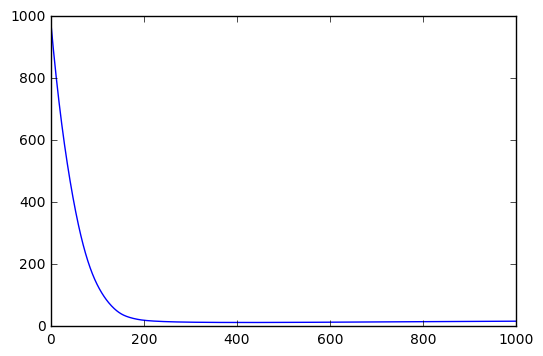

In [353]:
training_steps = 1000
out = []
plt.ion()
for i in range(training_steps):
    pred, err = train(D.xTr, D.yTr)
    out.append(err.sum())
plt.plot(out)

In [354]:
print('Error: %.2f' % (1 - (predict(D.xTr) == D.yTr).mean()))

Error: 0.00


In [432]:
# print('expected\tactual')
# for a,b in zip(predict(D.xTr), D.yTr):
#     print('%d\t\t%d\t%s' % (a,b,'WRONG' if a!=b else ''))

## Derivatives

### Computing gradients

In [393]:
x = T.dscalar('x')
y = T.sin(x)
gy = T.grad(cost=y, wrt=x)

In [394]:
f = function([x], gy)
g = function([x], y)

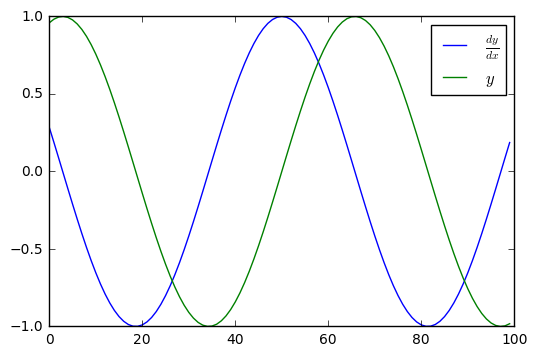

In [410]:
plt.plot([f(i/10)[()] for i in range(-50, 50)])
plt.plot([g(i/10)[()] for i in range(-50, 50)])
plt.legend([r"$\frac{dy}{dx}$", r'$y$'])

## Conditions

In [421]:
a, b = T.scalars('a', 'b')
x,y = T.matrices('x', 'y')
z_switch = T.switch(a < b, x.mean(), y.mean())
z_lazy = ifelse.ifelse(a < b, x.mean(), y.mean())
f_switch = function([a,b,x,y], z_switch, mode=Mode(linker='vm'))
f_lazy = function([a,b,x,y], z_lazy, mode=Mode(linker='vm'))

In [429]:
val1 = 0.
val2 = 1.
big_mat1 = np.ones((10000, 1000))
big_mat2 = np.ones((10000, 1000))

t0 = time.time()
for i in range(100):
    f_switch(val1, val2, big_mat1, big_mat2)
print('Time taken with switch: %.2fs' % (time.time() - t0))

t0 = time.time()
for i in range(100):
    f_lazy(val1, val2, big_mat1, big_mat2)
print('Time taken with lazy: %.2fs' % (time.time() - t0))

Time taken with switch: 2.16s
Time taken with lazy: 1.09s


## Loop

### Scan

Computing tanh(x(t).dot(W) + b) elementwise

In [430]:
# defining the tensor variables
X = T.matrix("X")
W = T.matrix("W")
b_sym = T.vector("b_sym")

In [434]:
results, updates = scan(lambda v: T.tanh(v.dot(W) + b_sym), sequences=X)
compute_elementwise = function(inputs=[X, W, b_sym], outputs=results)

In [441]:
# test values
x = np.eye(2)
w = np.ones((2, 2))
b = np.ones((2))
b[1] = 2

In [445]:
np.tanh(x.dot(w) + b)

array([[ 0.96402758,  0.99505475],
       [ 0.96402758,  0.99505475]])

In [452]:
compute_elementwise(x,w,b)

array([[ 0.96402758,  0.99505475],
       [ 0.96402758,  0.99505475]])

Computing the sequence x(t) = tanh(x(t - 1).dot(W) + y(t).dot(U) + p(T - t).dot(V))

In [461]:
# define tensor variables
X, b_sym = T.vectors('X', 'b_sym')
W, U, Y, V, P = T.matrices('W', 'U', 'Y', 'V', 'P')

results, updates = scan(lambda y, p, x_tm1: T.tanh(y.dot(U) + p.dot(V) + x_tm1.dot(W)),
                        sequences=[Y, P[::-1]], outputs_info=[X])
compute_seq = function(inputs=[X, W, Y, U, P, V], outputs=results)

In [468]:
# test values
x = np.array([0., 1])
w = np.ones((2, 2))
y = np.ones((5, 2))
y[0, :] = -3
u = np.ones((2, 2))
p = np.ones((5, 2))
p[0, :] = 3
v = np.ones((2, 2))

Computing pow(A, k)

In [492]:
# Symbolic description of the result
k = T.iscalar('k')
A = T.vector('A')

results, updates = scan(fn=lambda prior_result, B: prior_result * B, outputs_info=T.ones_like(A), non_sequences=A, n_steps=k)
power = function(inputs=[A, k], outputs=results, updates=updates)

In [497]:
power([i for i in range(8)], 3)

array([[   0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.],
       [   0.,    1.,    4.,    9.,   16.,   25.,   36.,   49.],
       [   0.,    1.,    8.,   27.,   64.,  125.,  216.,  343.]])

## How Shape Information is Handled by Theano

In [498]:
x = T.matrix('x')
f = function([x], (x ** 2).shape)

In [532]:
x, y = T.matrices('x', 'y')
z = T.join(0, x, y)

xv = np.random.rand(5,4)
yv = np.random.rand(3,3)

In [533]:
f = function([x, y], z.shape)

In [534]:
f(xv, yv) # WRONG!!! cannot call join on such matrices

array([8, 4])

In [535]:
f = function([x, y], z)

In [537]:
f(xv, yv) # returns error as expected

ValueError: all the input array dimensions except for the concatenation axis must match exactly
Apply node that caused the error: Join(TensorConstant{0}, x, y)
Toposort index: 0
Inputs types: [TensorType(int8, scalar), TensorType(float64, matrix), TensorType(float64, matrix)]
Inputs shapes: [(), (5, 4), (3, 3)]
Inputs strides: [(), (32, 8), (24, 8)]
Inputs values: [array(0, dtype=int8), 'not shown', 'not shown']
Outputs clients: [['output']]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/Users/m/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/m/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/m/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/m/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/m/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/m/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/m/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-532-c0a246de57a4>", line 2, in <module>
    z = T.join(0, x, y)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

# Advanced